# PyCaret with Synthetic Data for Real-Time Credit Card Fraud detection

[Credit card fraud is on the rise](https://www.forbes.com/sites/billhardekopf/2021/09/17/this-week-in-credit-card-news-huge-increase-in-fraudulent-mobile-apps-a-rosy-holiday-sales-outlook/?sh=385215f866a1) with the increase of online transactions due to COVID-19.  

In this use case, we will attempt a couple of fun things:
- [Generate synthetic data for machine learning](./01-Synthetic-data-generation.ipynb)
- [Test out the autoML PyCaret in predicting the fraudulent cases](./02_AutoML_PyCaret.ipynb)
- Integrate the prediction into atoti for real-time credit card reporting

The use case is only for illustrative purpose to show how atoti can be integrated with machine learning to achieve monitoring objective.  

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=creditcard-fraud-detection" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover.png" alt="Try atoti"></a></div>

## 1. Generating Synthetic Data

The __sparkov_data_generation__ package used in this use case is forked from the GitHub repo [Synthetic Credit Card Transaction Generator used in the Sparkov program](https://github.com/namebrandon/Sparkov_Data_Generation).  

Use [01-Synthetic-data-generation.ipynb](./01-Synthetic-data-generation.ipynb) to generate the synthetic data or download the pre-generated data from atoti s3 folder.

In [1]:
import os
import time
from zipfile import ZipFile

import faker
import pandas as pd
import wget
from faker import Faker
from IPython.display import clear_output, display
from pycaret.classification import *
from utils import data_prep

import atoti as tt

In [2]:
data_path = "./output"

Uncomment and run the below two cells to download the pre-generated synthetic data.

In [3]:
# def bar_custom(current, total, width=80):
#     clear_output(wait=True)
#     print("Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total))


# url = "https://data.atoti.io/notebooks/credit-card-fraud/output.zip"
# filename = wget.download(url, bar=bar_custom)

In [4]:
# # unzipping the file
# with ZipFile("data.zip", "r") as zipObj:
#     # Extract all the contents of zip file in current directory
#     zipObj.extractall(data_path)

## 2. Creating atoti cube for data exploration

We load the synthetic data into atoti tables and spin up a multidimensional cube to explore the data.  
To begin, we create an atoti session.

### 2.1 Create atoti session with SessionConfig
Below, we configured the [`SessionConfig`](https://docs.atoti.io/latest/lib/atoti.config.session_config.html#atoti.config.session_config.SessionConfig) with:
- user_content_storage: for persisting dashboards
- port: fix the port number, otherwise a random port will be assigned for the web application

In [5]:
session = tt.create_session(config={"user_content_storage": "./content", "port": 10327})

atoti can load CSV directly into the table. However, we will be performing machine learning on the data set later on in the notebook.  
So, let's read the customers and transactions data into a Pandas DataFrame.

In [6]:
cust_df = pd.read_csv(
    f"{data_path}/post_process_customer_list.csv", parse_dates=["dob"]
)

txns_df = pd.read_csv(
    f"{data_path}/post_process_transaction_list.csv", parse_dates=["trans_date"]
)

Below are some columns that should be treated as strings even though they are of numerical values. This is so that they will be automatically created as hierarchies instead of measures (Refer to [mode for create_cube](https://docs.atoti.io/latest/lib/atoti.session.html#atoti.session.Session.create_cube)).

In [7]:
common_col = ["ssn", "cc_num", "acct_num"]
cust_non_num_col = ["ssn", "cc_num", "acct_num", "zip"]
txn_non_num_col = [
    "ssn",
    "cc_num",
    "acct_num",
    "trans_num",
    "unix_time",
    "merchant_id",
    "is_fraud",
    "txn_during_night",
    "trans_weekend",
]

Let's cast the data types for the columns before loading them into the cube.

In [8]:
cust_df[cust_non_num_col] = cust_df[cust_non_num_col].astype(str)
txns_df[txn_non_num_col] = txns_df[txn_non_num_col].astype(str)

### 2.2 Load data into atoti table

We can load data into atoti with either:
- read_*: create an atoti table and loads the data
- load_*: load data into an existing atoti table

Below, we will load data for the customers and transactions into atoti tables with [`read_pandas`](https://docs.atoti.io/latest/lib/atoti.session.html#atoti.session.Session.read_pandas).  

#### 2.2.1 Base table - transaction

Transactions is more granular than customers. Since we are following the [snowflake schema](https://en.wikipedia.org/wiki/Snowflake_schema#:~:text=In%20computing%2C%20a%20snowflake%20schema,diagram%20resembles%20a%20snowflake%20shape.&text=The%20principle%20behind%20snowflaking%20is,attributes%20and%20forming%20separate%20tables.), we will choose the transaction table as our base table for cube creation.

In [9]:
txn_tbl = session.read_pandas(
    txns_df,
    table_name="transactions",
    keys=["ssn", "cc_num", "acct_num", "trans_num"],
)

In [10]:
txn_tbl.head()

,,,,profile,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merchant_id,merch_long,merch_lat,distance_from_cust,txn_during_night,trans_weekend,nb_trans_1days,cust_avg_amt_1days,nb_trans_7days,cust_avg_amt_7days,nb_trans_30days,cust_avg_amt_30days
acct_num,trans_num,cc_num,ssn,,,,,,,,,,,,,,,,,,,,
650277300926,78a301f6c1d629851f2134f3d428bd64,6011254895433784,651-85-6277,adults_2550_male_rural.json,2021-06-01,00:03:16,1622505796,grocery_pos,94.07,0,fraud_Barton Inc,191095,-80.583026,34.505328,65.125066,1,0,1.0,94.07,1.0,94.07,1.0,94.07
359048776675,b1f41c9941a8fef0c58b7da9c53b87d1,3561104445052090,829-65-8471,adults_2550_female_urban.json,2021-06-01,00:05:54,1622505954,misc_net,2.52,0,fraud_Ruecker Group,156108,-74.303208,40.728483,67.922169,1,0,1.0,2.52,1.0,2.52,1.0,2.52
457496356031,4c277b5b47525ffd52919af6c80f292a,30177657960332,765-51-3253,adults_50up_male_urban.json,2021-06-01,00:06:50,1622506010,food_dining,40.44,0,fraud_Haag-Blanda,289878,-87.214427,42.418391,53.756976,1,0,1.0,40.44,1.0,40.44,1.0,40.44
261496133542,a24a9cfd2eb04f1e477c8b2b28f57bd7,4893518176925451756,843-90-9424,adults_2550_male_urban.json,2021-06-01,00:09:07,1622506147,grocery_pos,82.00,0,fraud_Bauch-Raynor,418020,-97.492732,36.430343,105.722978,1,0,1.0,82.00,1.0,82.00,1.0,82.00
840477491610,2ecedf1776c3de3f8e87cd4842f855f4,3510018921883087,201-15-2262,adults_2550_male_rural.json,2021-06-01,00:10:19,1622506219,grocery_pos,82.95,0,fraud_Kiehn-Emmerich,337806,-76.540490,43.925550,25.989622,1,0,1.0,82.95,1.0,82.95,1.0,82.95


In [11]:
len(txn_tbl)

384168

#### 2.2.2 Referenced table - customer

We can create referenced table before or after cube creation. Referenced tables are join to the cube to [enrich it](https://docs.atoti.io/latest/tutorial/tutorial.html#Enriching-the-cube).

In [12]:
customer_tbl = session.read_pandas(
    cust_df,
    table_name="customer",
    keys=common_col,
)

In [13]:
len(customer_tbl)

9334

In [14]:
customer_tbl.head()

,,,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,profile,age
acct_num,cc_num,ssn,,,,,,,,,,,,,,
650277300926,6011254895433784,651-85-6277,Noah,Mendez,M,1597 Michael Centers,Mc Farlan,NC,28102,34.8136,-79.9776,78,"Engineer, communications",1985-06-13,adults_2550_male_rural.json,36
359048776675,3561104445052090,829-65-8471,Erin,Koch,F,953 Michelle Parkways,Armonk,NY,10504,41.1360,-73.7009,7987,"Editor, film/video",1978-12-29,adults_2550_female_urban.json,42
457496356031,30177657960332,765-51-3253,James,Johnson,M,5703 Serrano Flat Suite 301,North Chicago,IL,60064,42.3247,-87.8564,15407,"Therapist, music",1958-06-15,adults_50up_male_urban.json,63
261496133542,4893518176925451756,843-90-9424,Anthony,Dunn,M,2878 Alexander Fort Suite 819,Oklahoma City,OK,73117,35.4797,-97.4722,640470,"Engineer, site",1989-07-08,adults_2550_male_urban.json,32
840477491610,3510018921883087,201-15-2262,Todd,Dennis,M,00956 Knapp Extensions Apt. 972,Henderson,NY,13650,43.8467,-76.2352,1391,"Physicist, medical",1973-12-20,adults_2550_male_rural.json,47


#### 2.2.3 Create empty atoti table - prediction

The PyCaret prediction output 2 columns:
- Label
- Score

With [`atoti.create_table`](https://docs.atoti.io/latest/lib/atoti.session.html#atoti.session.Session.create_table), we can create an empty table. We will need to define the columns, its expected data type as well as the table keys (if any).

In [15]:
prediction_tbl = session.create_table(
    name="prediction",
    types={
        "trans_num": tt.type.STRING,
        "Label": tt.type.STRING,
        "Score": tt.type.FLOAT,
    },
    keys=["trans_num"],
)

To demonstrate how we can load data into an existing table, we will load the prediction from the LGBM model for July into `prediction_tbl`:

In [16]:
prediction_tbl.load_csv(f"{data_path}/july_aug_prediction_lgbm.csv")

In [17]:
prediction_tbl.head()

,Label,Score
trans_num,,
e14e1a05c8da5e3f3da457e6eb84d825,0,1.0
a3c0100cb4cfb7a5c4ffc90faaf7a6d8,0,1.0
9952d8bafe837216db5134d988d5144a,0,1.0
d2e9179d1401f84883b5d842d6ea0bbd,0,1.0
e49b8faa1f65e5444097815a3eabfdb4,0,1.0


### 2.3 Join tables

We join the referenced table _customer_ to the base table _transaction_. We did not explicity configure the mapping as atoti automatically infers the join based on the common column names.  

We can also join any new tables to the base table after the cube is created.

Refer to the [join examples in tutorial](https://docs.atoti.io/latest/tutorial/tutorial.html#Join) for more details.

In [18]:
txn_tbl.join(customer_tbl)
txn_tbl.join(prediction_tbl, mapping={"trans_num": "trans_num"})

### 2.4 Create cube

We create the cube with the base table. Cube name `credit_card_trans` is optional.

In [19]:
cube = session.create_cube(txn_tbl, "credit_card_trans")

#### 2.4.1 View cube schema

Once the cube is created, we can visualize the cube schema. If you [installed atoti via Python package managers such as pip](https://docs.atoti.io/latest/installation.html#python-package), you need to install  [graphviz](https://www.graphviz.org/download/) to do this step.

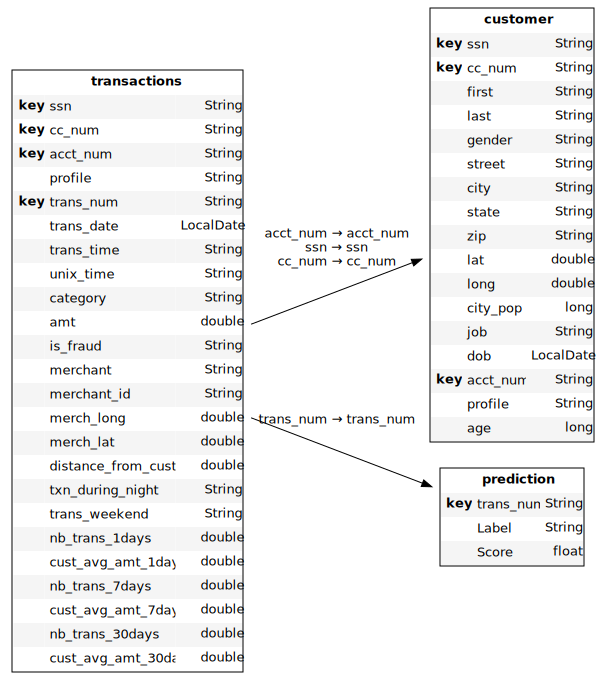

In [20]:
cube.schema

#### 2.4.2 Alias cube hierarchies property

We can manipulate the below aspects of the cube. Aliasing the hierarchies property makes it more convenient for use later on.

In [21]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

### 2.5 Access web aplication

Upon session creation, a web application is launched. However, without any cubes, we can't perform any analysis on the web application.  

Run [`session.link( )`](https://docs.atoti.io/latest/lib/atoti.session.html#atoti.session.Session.link) to retrieve the URL of the web application.

In [22]:
session.link()

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

### 2.6 Visualize data in Jupyter notebook

Once the cube is created, we can make use of the atoti JupyterLab extension to [create visualization](https://docs.atoti.io/latest/tutorial/tutorial.html#First-visualization) interactively. Let's take a quick look at the number of fraudulent and non-fraudulent transactions.  

#### 2.6.1 Showing text on charts

At the moment, we can enable text display on the chart by editing the Jupyter notebook's Cell Metadata to add `"isTextVisible": true` under the `widget` node:
<img src="img/showText.png" width="80%"/>   

From the chart below, we can see that the number of fraudulent cases is less than 5%.

In [23]:
session.visualize("0 - Non-fraudulent, 1 - Fraudulent")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Let's look at the time when the frauds occurred. It seems that most fraudulent transactions happened in the night and on weekdays.

In [24]:
session.visualize(
    "Number of frauds occurring between day and night (0 - Day, 1 - Night)"
)

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [25]:
session.visualize(
    "Number of frauds occurring between weekday and weekend (0 - Weekday, 1 - Weekend)"
)

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### 2.6.2 Subplots

Simply add the levels to the vertical or horizontal subplot section in the atoti JupyterLab extension.  

We ought to be careful of those merchants with low transaction volume and high occurrence of fraud, likely a dubious merchant. Though, it's also likely the higher the transaction volume, the more susceptible the merchant is to external fraud.

In [26]:
session.visualize("Merchants with highest fraudulent occurence on 29th Aug")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Is it coincidence that some merchants have multiple fraudulent transactions within a day?

### 2.7 Creating measures 

Measures in atoti is computed on the fly as we query the cube. When a cube is created in [auto mode](https://docs.atoti.io/latest/lib/atoti.session.html#atoti.session.Session.create_cube), a ".SUM" and a ".MEAN" measures are created for numerical columns of the base table. Measures are not created for the referenced table.

We can make use of the `cube.measures` property to define new measures. 

#### 2.7.1 Compute measures for referenced table 

Customer table is a referenced table. Hence, we have to create the necesary measures manually.  
We can do so with [`atoti.value`](https://docs.atoti.io/latest/lib/atoti.html#atoti.value) which will return the measure value when queried at levels corresponding to the keys of column's table. Alternatively, we can perform aggregation on the table column, which is what we will do in this case. 

Below, we create the measures for customer's longitude, latitude and age.

In [27]:
m["cust_long"] = tt.agg.mean(customer_tbl["long"])
m["cust_lat"] = tt.agg.mean(customer_tbl["lat"])
m["cust_age"] = tt.agg.mean(customer_tbl["age"])

In [28]:
session.visualize(
    "Customers avg number of transactions in 1 day on 29th Aug - (x-axis: longitude, y-axis: latitude)"
)

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Similarly, we will create the measure `score` for the prediction table with the [summation aggregator](https://docs.atoti.io/latest/lib/atoti.agg.html#atoti.agg.sum).

In [29]:
m["score"] = tt.agg.sum(prediction_tbl["Score"])
m["score"].formatter = "DOUBLE[#,###.000]"

#### 2.7.2 Count distinct values

We should be seeing increase in customers over the months. Let's create some measures to see if this increase affects the number of fraudulent transactions.

We count the number of active customers in order to see if the increase in transactions is also due to increase in customer. We can use the atoti function [`count_distinct`](https://docs.atoti.io/latest/lib/atoti.agg.html#atoti.agg.count_distinct) on the table column that stores the identified for customer, `ssn` (Social Security Number) in this case.

In [30]:
m["nb_active_customers"] = tt.agg.count_distinct(customer_tbl["ssn"])

#### 2.7.3 Filter

We can use the [`filter`](https://docs.atoti.io/latest/lib/atoti.html#atoti.filter) to apply filter on a measure. In this case, we want the count where the transactions are marked as fraudulent.

In [31]:
m["nb_fraudulent_txns"] = tt.filter(m["contributors.COUNT"], l["is_fraud"] == "1")

#### 2.7.4 Chain measures 

We can define a measure on top of other measures. For instance:

In [32]:
m["%_fraud_txns"] = m["nb_fraudulent_txns"] / m["contributors.COUNT"]
m["%_fraud_txns"].formatter = "DOUBLE[#.000%]"

Any updates to `m["nb_fraudulent_txns"]` will have cascading effect on `m["%_fraud_txns"]`.

Let's sum up the total amount loss to fraud and see the percentage loss.

In [33]:
m["fraudulent_txn_amt"] = tt.agg.sum(
    tt.where((l["is_fraud"] == "1"), m["amt.SUM"]),
    scope=tt.scope.origin(l["trans_date"], l["is_fraud"]),
)

m["%_loss_to_fraud"] = tt.where(
    m["fraudulent_txn_amt"] == 0, 0, m["fraudulent_txn_amt"] / m["amt.SUM"]
)
m["%_loss_to_fraud"].formatter = "DOUBLE[#.000%]"

We can now see which are the merchants with more than 50% fraudulent transactions. There are five merchants with 100% fraudulent transactions.  

##### Tips: Color coding table with MDX
At the moment, we can manipulate the MDX from the Jupyter notebook's Cell Metadata to color the fonts conditionally:
```
WITH  Member [Measures].[%_fraud_txns (1)] AS [Measures].[%_fraud_txns], FORE_COLOR = CASE WHEN [Measures].[%_fraud_txns (1)] > 0.25 THEN rgb(245, 66, 66) END, format_string=\"##.000%\", CAPTION = [Measures].[%_fraud_txns].MEMBER_CAPTION
```

In [34]:
session.visualize("Merchants with more than 25% percentage fraudulent transactions")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### 2.7.5 Different ways to create same measure

We can apply the below filter to get the non-fraudulent transactions.   
`m["nb_normal_txns"] = tt.filter(m["contributors.COUNT"], l["is_fraud"] == "0")`  

Alternatively, we can minus the `nb_fraudulent_txns` from the total count. However, any updates to `m["nb_fraudulent_txns"]` will have cascading effect on `m["nb_normal_txms"]`.

In [35]:
m["nb_normal_txns"] = m["contributors.COUNT"] - m["nb_fraudulent_txns"]

The measures will be available for visualization immediately in both Jupyter notebook and the web application.  

There is a gradual increase in the number of customer over time and the number of fraudulent transactions also seems to increase. However, there is a drop in the number of fraudulent transactions towards the end of September. The overall number of transactions during the same period also fell.

In [36]:
session.visualize("Fraud trend")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### 2.8 Drillthrough to view underlying data 

Right-click on the `nb_fraudulent_txns` in the chart on 29th Aug (the day with the highest number of fraud occurrence). A context menu will be displayed.  
Select "Drillthrough on 2021-08-29" to look at the underlying transactions.
<img src="img/drillthrough.png" width="80%"/>   

A new cell displaying the drillthrough widget will be displayed. Use the atoti JupyterLab extension on the left to select the features to review.

In [37]:
session.visualize("Drillthrough on 29th Aug")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### 2.9 Sorting levels

A hierarchy can have one or multiple levels. Therefore, if we would like a default order for a given column, we apply [comparator](https://docs.atoti.io/latest/lib/atoti.comparator.html#atoti.comparator.Comparator) on the _level_.  

As we monitoring the transactions real-time, we would likely want the transactions from the latest date to be more easily accessible. So we apply the descending comparator on the `l["trans_date"]`.

In [38]:
l["trans_date"].comparator = tt.comparator.DESCENDING

### 2.10 Manipulating hierarchies

#### 2.10.1 Create date hierarchy from date column

To visualize yearly or monthly data based on the transaction dates, we can create a new hierarchy as shown below.  
We can also create weekly or quarterly hierarchy if needed. Refer to [atoti documentation](https://docs.atoti.io/latest/lib/atoti.experimental.html#atoti.experimental.create_date_hierarchy) for more information.  

The [date pattern](https://docs.oracle.com/en/java/javase/15/docs/api/java.base/java/time/format/DateTimeFormatter.html#patterns) used below _creates levels of type String_,

In [39]:
tt.experimental.create_date_hierarchy(
    "Transaction Dates",
    cube=cube,
    column=txn_tbl["trans_date"],
    levels={"Year": "yyyy", "Month": "MM", "Day": "dd"},
)

Using the visualization type __KPI__, we can show the difference in amount loss to fraud between the different months.

In [40]:
session.visualize("Amount loss to fraud comparison in last 2 months")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

There is an increasing trend in the amount lost to fraud, having a fifth of the transaction amount lost to fraud in August.

In [41]:
session.visualize("Amount loss to fraud")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### 2.11 Create table for classification 

We can always add additional tables to the cube without having to restart the session. Let's create another atoti table to group the customers' age. 

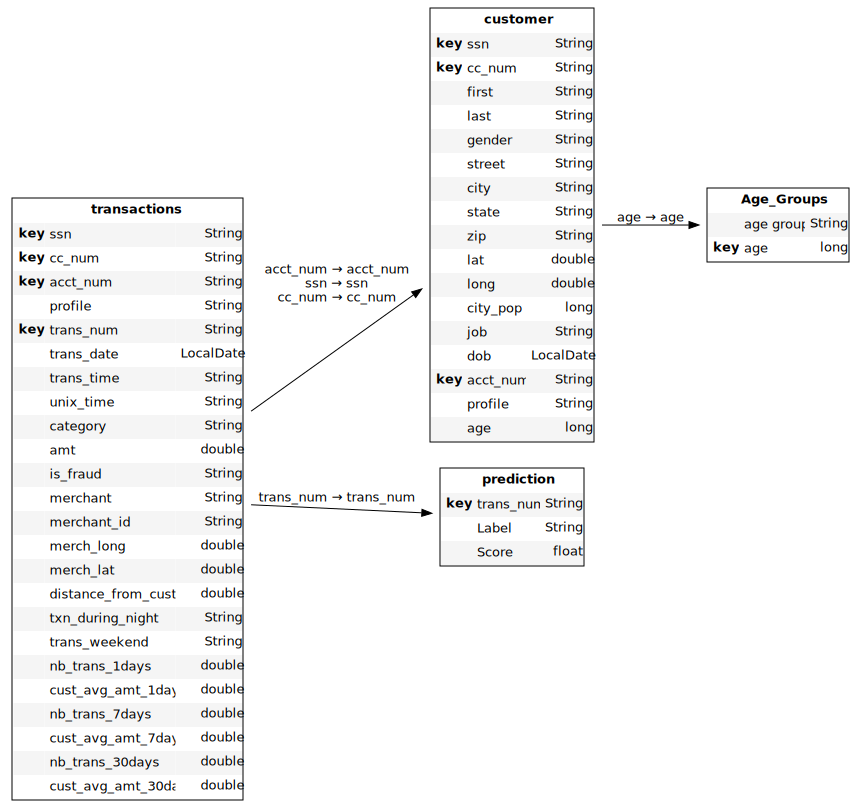

In [42]:
age_groups_store = session.read_pandas(
    pd.DataFrame(
        data=[("0-25Y", i) for i in range(25)]
        + [("25Y - 40Y", i) for i in range(25, 40)]
        + [("40Y - 55Y", i) for i in range(40, 55)]
        + [("55Y+", i) for i in range(55, 100)],
        columns=["age group", "age"],
    ),
    keys=["age"],
    table_name="Age_Groups",
)

customer_tbl.join(age_groups_store)

cube.schema

We can now tell that the youngest and oldest tier are more susceptible to fraud.

In [43]:
session.visualize("% loss to fraud by age group")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## 3. Integrate prediction from AutoML (PyCaret) into atoti

Using [PyCaret](https://pycaret.org/), we trained and tested 3 months worth of synthetic credit card transactions.  
The trained models are being saved under the __models__ folder.  

### 3.1 Create atoti KPI based on the predictions

#### 3.1.1 Create similar KPI as actual fraud for predicted fraud

Instead of using `is_fraud` which indicates true fraud cases, we will use `Label` to create similar KPIs.

In [44]:
m["nb_predicted_fraud_txns"] = tt.filter(m["contributors.COUNT"], l["Label"] == "1")
m["%_predicted_fraud_txns"] = m["nb_predicted_fraud_txns"] / m["contributors.COUNT"]

m["%_predicted_fraud_txns"].formatter = "DOUBLE[#.000%]"

In [45]:
m["predicted_fraud_txn_amt"] = tt.agg.sum(
    tt.where((l["Label"] == "1"), m["amt.SUM"]),
    scope=tt.scope.origin(l["trans_date"], l["is_fraud"], l["Label"]),
)
m["%_predicted_loss_to_fraud"] = tt.where(
    m["predicted_fraud_txn_amt"] == 0, 0, m["predicted_fraud_txn_amt"] / m["amt.SUM"]
)

m["%_predicted_loss_to_fraud"].formatter = "DOUBLE[#.000%]"

In [46]:
m["diff_with_actual_txn_amt"] = m["fraudulent_txn_amt"] - m["predicted_fraud_txn_amt"]
m["diff_with_actual_nb_fraud_txn"] = (
    m["nb_fraudulent_txns"] - m["nb_predicted_fraud_txns"]
)

Since we have the prediction for July, let's visualize this value against the actual fraud. But we haven't take the recall and precision into account.

In [47]:
session.visualize("Difference between actual and predicted")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### 3.1.2 Compute recall and precision for prediction

We can plot the confusion matrix with the actual frauds `is_fraud` on rows and predicted fraud `Label` on columns.  
This shows that out of the 10,305 fraudulent transactions in July and Aug, we predicted 8,757 of them correctly.

In [48]:
session.visualize("Confusion matrix")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In fact, we can also compute the recall and precision for the prediction with atoti:

In [49]:
m["true_positive"] = tt.agg.sum(
    tt.where((l["Label"] == "1") & (l["is_fraud"] == "1"), m["contributors.COUNT"]),
    scope=tt.scope.origin(l["trans_date"], l["is_fraud"], l["Label"]),
)

m["true_negative"] = tt.agg.sum(
    tt.where((l["Label"] == "0") & (l["is_fraud"] == "0"), m["contributors.COUNT"]),
    scope=tt.scope.origin(l["trans_date"], l["is_fraud"], l["Label"]),
)

m["false_positive"] = tt.agg.sum(
    tt.where((l["Label"] == "1") & (l["is_fraud"] == "0"), m["contributors.COUNT"]),
    scope=tt.scope.origin(l["trans_date"], l["is_fraud"], l["Label"]),
)

m["false_negative"] = tt.agg.sum(
    tt.where((l["Label"] == "0") & (l["is_fraud"] == "1"), m["contributors.COUNT"]),
    scope=tt.scope.origin(l["trans_date"], l["is_fraud"], l["Label"]),
)

m["accuracy"] = (m["true_positive"] + m["true_negative"]) / m["contributors.COUNT"]
m["precision"] = m["true_positive"] / (m["true_positive"] + m["false_positive"])
m["recall"] = m["true_positive"] / (m["true_positive"] + m["false_negative"])

From the below table, we can see that the accuracy rate of the Light Gradient Boosting Machine has accuracy of 99% which is very high.

In [50]:
session.visualize("Performance of the LGBM model against July prediction")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Let's look at the performance from the monetary perspective.

In [51]:
m["true_positive_amt"] = tt.agg.sum(
    tt.where((l["Label"] == "1") & (l["is_fraud"] == "1"), m["amt.SUM"]),
    scope=tt.scope.origin(l["trans_date"], l["is_fraud"], l["Label"]),
)

m["false_positive_amt"] = tt.agg.sum(
    tt.where((l["Label"] == "1") & (l["is_fraud"] == "0"), m["amt.SUM"]),
    scope=tt.scope.origin(l["trans_date"], l["is_fraud"], l["Label"]),
)

m["false_negative_amt"] = tt.agg.sum(
    tt.where((l["Label"] == "0") & (l["is_fraud"] == "1"), m["amt.SUM"]),
    scope=tt.scope.origin(l["trans_date"], l["is_fraud"], l["Label"]),
)

m["% amt loss prevented"] = m["true_positive_amt"] / m["fraudulent_txn_amt"]
m["% amt loss prevented"].formatter = "DOUBLE[##.00%]"

`true_positive_amt`: if preventive actions were taken against these transactions, __more than a million dollars will be saved__ from fraudulent activities.  
`false_positive_amt`: even though falsely predicted, it's better to be safe than sorry.  
`false_negative_amt`: fraudulent transactions missed by the machine learning and resulted in actual loss.  
`% amt loss prevented`: prevents __more than 90% of the actual fraudulent transaction amount__ from actual loss.

In [52]:
session.visualize("Transaction amount saved/lost to fraud after preventive actions")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### 3.1.3 Place measures in folder  

Since atoti is a Python library, we can iterate through the measures to put them in folders conditionally.

In [53]:
for measure_name in m.keys():
    if "predicted" in measure_name:
        m[measure_name].folder = "Prediction"

In [54]:
for measure in [
    m["true_positive"],
    m["true_negative"],
    m["false_positive"],
    m["false_negative"],
    m["accuracy"],
    m["precision"],
    m["recall"],
    m["true_positive_amt"],
    m["false_positive_amt"],
    m["false_negative_amt"],
    m["% amt loss prevented"],
]:
    measure.folder = "Evaluation"

### 3.2 Launch real-time dashboard 

After we have created all the KPIs, we can design our real-time dashboard. Access the saved dashboard from the link below:

In [55]:
session.link(path="/#/dashboard/4c8")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

### 3.3 Load saved ML model

Now, we can start our prediction by first loading 2 of the better performing models among the trained ones:
- Light Gradient Boosting Machine (LGBM)
- Decision Tree Classifier (DT)  

Refer to [02_AutoML_PyCaret.ipynb](./02_AutoML_PyCaret.ipynb) for the model evaluation.

In [56]:
model_path = "./models/"

In [57]:
saved_final_lgbm = load_model(f"{model_path}Final LGBM Model 20211113")

Transformation Pipeline and Model Successfully Loaded


In [58]:
saved_final_dt = load_model(f"{model_path}Final DT Model 20211113")

Transformation Pipeline and Model Successfully Loaded


### 3.4 Perform prediction on real-time data

We will iterate through the September transactions that was put aside from the ML modeling previously.  
For each iteration, we will perform the prediction and load the results back into atoti, along with the transactions.  

We can monitor the various KPI for fraud investigation.  

#### 3.4.1 Features to be passed to model

In [59]:
feature_list = [
    "category",
    "amt",
    "is_fraud",
    "merchant_id",
    "gender",
    "street",
    "city",
    "state",
    "zip",
    "city_pop",
    "job",
    "age",
    "distance_from_cust",
    "txn_during_night",
    "trans_weekend",
    "nb_trans_1days",
    "cust_avg_amt_1days",
    "nb_trans_7days",
    "cust_avg_amt_7days",
    "nb_trans_30days",
    "cust_avg_amt_30days",
]

#### 3.4.2 Throttling transaction data reading

Using the [`chunksize`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) from Pandas, we can choose the number of rows to read per iteration. We have data for the month of September, so we can adjust the chunksize for longer or shorter data loading duration (to achieve real-time demo effect).

In [60]:
new_txns_df = pd.read_csv(
    f"{data_path}/realtime_txn.csv",
    # f"{data_path}/temp_txns.csv",
    parse_dates=["trans_date"],
    chunksize=5000,
)

#### 3.4.3 Custom prediction function

The function below does the following: 
1. computes the features required as per [02_AutoML_PyCaret.ipynb](./02_AutoML_PyCaret.ipynb)
2. invoke the [`predict_model`](https://pycaret.org/predict-model/) function on the features data with the selected model
3. load the prediction into the prediction table created earlier on (2.2.3)
4. load transactions into the transaction table

In [61]:
def run_prediction(_txn_df, model, save_features=False, debug=False):

    _txn_df[common_col] = _txn_df[common_col].astype(str)

    # perform data transformation
    if debug == True:
        print("Generating additional features for transaction")

    features_df = data_prep.compute_features(cust_df, _txn_df, ignore_cust=True)
    features_df.reset_index(drop=True, inplace=True)

    # perform prediction
    if debug == True:
        print(". Performing machine learning prediction")

    features = features_df[feature_list]

    if debug == True:
        print("****", features.head(3))

    model_prediction = predict_model(model, data=features)
    if debug == True:
        print("^^^^^", model_prediction.head(3))

    # merge prediction results back to original dataset
    features_df = features_df.merge(model_prediction)

    features_df[["trans_num", "Label"]] = features_df[["trans_num", "Label"]].astype(
        str
    )

    if debug == True:
        print("----- ", features_df[prediction_tbl.columns].head(3))
        print(".. Loading predictions into atoti")

    # load prediction
    prediction_tbl.load_pandas(features_df[prediction_tbl.columns])

    # load transaction
    realtime_txn_df = features_df[txns_df.columns].copy()
    realtime_txn_df[txn_non_num_col] = realtime_txn_df[txn_non_num_col].astype(str)

    if debug == True:
        print("... Loading transactions into atoti")

    txn_tbl.load_pandas(realtime_txn_df)

    # output transaction from 2021-09-01 to csv for scenario testing
    # skip this if we are using the downloaded, preprocessed features for scenario testing
    if save_features == True:
        features_df.to_csv(
            f"{data_path}/features.csv",
            mode="a",
            header=not os.path.exists(f"{data_path}/features.csv"),
            index=False,
        )

#### 3.4.4 Iterate dataset for prediction

We perform fraud prediction with the _Light Gradient Boosting Machine_ model which has the best AUC.  
Set `save_features` to `True` if you prefer to output the computed features to csv during the iteration. We can use it to perform prediction with other ML models.

In [62]:
for chunk in new_txns_df:
    run_prediction(chunk, saved_final_lgbm)  # save_features=True
    time.sleep(3)

### 3.5 Model comparison with atoti source simulation

How will the _Decision Tree Classifier_ model perform against _Light Gradient Boosting Machine_ model? Let's run the same dataset with the _Decision Tree Classifier_ model and load into atoti as a scenario.  

Instead of using the features output in the previous step, we will use the downloaded features.csv which is saved in advance.

In [63]:
simulation_features_df = pd.read_csv(f"{data_path}/features.csv")
print(len(simulation_features_df))
simulation_features_df.head()

313158


,ssn,cc_num,acct_num,profile,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merchant_id,merch_long,merch_lat,distance_from_cust,txn_during_night,trans_weekend,nb_trans_1days,cust_avg_amt_1days,nb_trans_7days,cust_avg_amt_7days,nb_trans_30days,cust_avg_amt_30days,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,age,Label,Score
0,735-45-9290,213109214812671,495169265617,adults_2550_male_urban.json,321c53a401db804354021fc3d9dfcbd3,2021-09-01,00:00:09,1630454409,misc_net,804.65,1,fraud_Ruecker Group,255855,-72.955077,41.918133,19.132311,1,0,1.0,804.65,1.0,804.65,1.0,804.65,Charles,Johnson,M,9100 Lori Burg,Harwinton,CT,6791,41.7701,-73.0728,5666,"Surveyor, planning and development",1993-02-14,28,1,0.6791
1,205-46-1240,4780052277877659098,134707507060,adults_2550_female_rural.json,be97b5bbfcd187e9427b486cf2e4c77c,2021-09-01,00:00:10,1630454410,grocery_pos,100.14,0,fraud_O'Keefe-Hudson,49009,-90.755922,42.796576,20.126778,1,0,1.0,100.14,1.0,100.14,1.0,100.14,Karen,Thomas,F,460 Jennifer Trail Suite 276,Glen Haven,WI,53810,42.8204,-91.0005,429,Mental health nurse,1989-11-18,31,0,1.0000
2,416-79-0328,6011979384832753,722623526084,adults_2550_female_urban.json,b8b93933c79e3950e61b30009423aa1b,2021-09-01,00:00:20,1630454420,grocery_pos,182.24,0,"fraud_Schoen, Kuphal and Nitzsche",219108,-75.375714,39.754468,65.830613,1,0,1.0,182.24,1.0,182.24,1.0,182.24,Michelle,Fox,F,08043 Casey Squares,Levittown,PA,19054,40.1681,-74.8231,64038,"Psychologist, clinical",1985-08-07,36,0,1.0000
3,408-62-3563,348107481747719,118535353289,adults_50up_male_urban.json,21563406d2fe8d25911f0afbd24039ae,2021-09-01,00:00:32,1630454432,food_dining,74.07,0,fraud_Kihn-Schuster,3765,-85.000750,42.936553,103.895208,1,0,1.0,74.07,1.0,74.07,1.0,74.07,Oscar,Richardson,M,647 Morse Mills,Saginaw,MI,48604,43.4732,-83.9514,135669,Press sub,1969-09-04,52,0,1.0000
4,087-34-6700,6531231787786181,984998546565,adults_2550_female_rural.json,e85c9b80a5c877e2d556fe694237f172,2021-09-01,00:00:33,1630454433,gas_transport,72.60,0,"fraud_Schaefer, Maggio and Daugherty",4539,-85.300995,41.100572,87.893559,1,0,1.0,72.60,1.0,72.60,1.0,72.60,Krystal,Kelley,F,64540 Sarah Ports,Salamonia,IN,47381,40.3818,-84.8669,145,"Sales professional, IT",1972-05-07,49,0,1.0000


In [64]:
simulate_5days_df = simulation_features_df.loc[
    (simulation_features_df["trans_date"] >= "2021-09-01")
    & (simulation_features_df["trans_date"] <= "2021-09-05")
]

In [65]:
simulate_5days_df.drop(columns=["Label", "Score"], inplace=True)
simulate_5days_df.reset_index(drop=True, inplace=True)
len(simulate_5days_df)

46455

In [66]:
simulate_5days_df.head()

,ssn,cc_num,acct_num,profile,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merchant_id,merch_long,merch_lat,distance_from_cust,txn_during_night,trans_weekend,nb_trans_1days,cust_avg_amt_1days,nb_trans_7days,cust_avg_amt_7days,nb_trans_30days,cust_avg_amt_30days,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,age
0,735-45-9290,213109214812671,495169265617,adults_2550_male_urban.json,321c53a401db804354021fc3d9dfcbd3,2021-09-01,00:00:09,1630454409,misc_net,804.65,1,fraud_Ruecker Group,255855,-72.955077,41.918133,19.132311,1,0,1.0,804.65,1.0,804.65,1.0,804.65,Charles,Johnson,M,9100 Lori Burg,Harwinton,CT,6791,41.7701,-73.0728,5666,"Surveyor, planning and development",1993-02-14,28
1,205-46-1240,4780052277877659098,134707507060,adults_2550_female_rural.json,be97b5bbfcd187e9427b486cf2e4c77c,2021-09-01,00:00:10,1630454410,grocery_pos,100.14,0,fraud_O'Keefe-Hudson,49009,-90.755922,42.796576,20.126778,1,0,1.0,100.14,1.0,100.14,1.0,100.14,Karen,Thomas,F,460 Jennifer Trail Suite 276,Glen Haven,WI,53810,42.8204,-91.0005,429,Mental health nurse,1989-11-18,31
2,416-79-0328,6011979384832753,722623526084,adults_2550_female_urban.json,b8b93933c79e3950e61b30009423aa1b,2021-09-01,00:00:20,1630454420,grocery_pos,182.24,0,"fraud_Schoen, Kuphal and Nitzsche",219108,-75.375714,39.754468,65.830613,1,0,1.0,182.24,1.0,182.24,1.0,182.24,Michelle,Fox,F,08043 Casey Squares,Levittown,PA,19054,40.1681,-74.8231,64038,"Psychologist, clinical",1985-08-07,36
3,408-62-3563,348107481747719,118535353289,adults_50up_male_urban.json,21563406d2fe8d25911f0afbd24039ae,2021-09-01,00:00:32,1630454432,food_dining,74.07,0,fraud_Kihn-Schuster,3765,-85.000750,42.936553,103.895208,1,0,1.0,74.07,1.0,74.07,1.0,74.07,Oscar,Richardson,M,647 Morse Mills,Saginaw,MI,48604,43.4732,-83.9514,135669,Press sub,1969-09-04,52
4,087-34-6700,6531231787786181,984998546565,adults_2550_female_rural.json,e85c9b80a5c877e2d556fe694237f172,2021-09-01,00:00:33,1630454433,gas_transport,72.60,0,"fraud_Schaefer, Maggio and Daugherty",4539,-85.300995,41.100572,87.893559,1,0,1.0,72.60,1.0,72.60,1.0,72.60,Krystal,Kelley,F,64540 Sarah Ports,Salamonia,IN,47381,40.3818,-84.8669,145,"Sales professional, IT",1972-05-07,49


#### 3.5.1 Perform prediction with _Decision Tree Classifier_ model

Due to the amount of data, we will only run the simulation for 5 days of data.  
It will take a while for the model prediction to complete. You may skip the autoML prediction and use the below _simulate_5days.csv_ to load into atoti if you prefer.

In [67]:
# simulate_5days_df = pd.read_csv(f"{data_path}/simulate_5days.csv")

In [68]:
dt_prediction = predict_model(saved_final_dt, data=simulate_5days_df[feature_list])
print(len(dt_prediction))

dt_prediction.head()

46455


,category,amt,is_fraud,merchant_id,gender,street,city,state,zip,city_pop,job,age,distance_from_cust,txn_during_night,trans_weekend,nb_trans_1days,cust_avg_amt_1days,nb_trans_7days,cust_avg_amt_7days,nb_trans_30days,cust_avg_amt_30days,Label,Score
0,misc_net,804.65,1,255855,M,9100 Lori Burg,Harwinton,CT,6791,5666,"Surveyor, planning and development",28,19.132311,1,0,1.0,804.65,1.0,804.65,1.0,804.65,1,0.8973
1,grocery_pos,100.14,0,49009,F,460 Jennifer Trail Suite 276,Glen Haven,WI,53810,429,Mental health nurse,31,20.126778,1,0,1.0,100.14,1.0,100.14,1.0,100.14,0,0.9924
2,grocery_pos,182.24,0,219108,F,08043 Casey Squares,Levittown,PA,19054,64038,"Psychologist, clinical",36,65.830613,1,0,1.0,182.24,1.0,182.24,1.0,182.24,0,0.8857
3,food_dining,74.07,0,3765,M,647 Morse Mills,Saginaw,MI,48604,135669,Press sub,52,103.895208,1,0,1.0,74.07,1.0,74.07,1.0,74.07,0,0.9924
4,gas_transport,72.60,0,4539,F,64540 Sarah Ports,Salamonia,IN,47381,145,"Sales professional, IT",49,87.893559,1,0,1.0,72.60,1.0,72.60,1.0,72.60,0,0.9924


Be sure to check that the `Label` and `Score` from the LGBM prediction is dropped from the `simulate_5_df` DataFrame.

In [69]:
merged_dt = simulate_5days_df.merge(dt_prediction)
print(len(merged_dt))

merged_dt.head()

46455


,ssn,cc_num,acct_num,profile,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merchant_id,merch_long,merch_lat,distance_from_cust,txn_during_night,trans_weekend,nb_trans_1days,cust_avg_amt_1days,nb_trans_7days,cust_avg_amt_7days,nb_trans_30days,cust_avg_amt_30days,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,age,Label,Score
0,735-45-9290,213109214812671,495169265617,adults_2550_male_urban.json,321c53a401db804354021fc3d9dfcbd3,2021-09-01,00:00:09,1630454409,misc_net,804.65,1,fraud_Ruecker Group,255855,-72.955077,41.918133,19.132311,1,0,1.0,804.65,1.0,804.65,1.0,804.65,Charles,Johnson,M,9100 Lori Burg,Harwinton,CT,6791,41.7701,-73.0728,5666,"Surveyor, planning and development",1993-02-14,28,1,0.8973
1,205-46-1240,4780052277877659098,134707507060,adults_2550_female_rural.json,be97b5bbfcd187e9427b486cf2e4c77c,2021-09-01,00:00:10,1630454410,grocery_pos,100.14,0,fraud_O'Keefe-Hudson,49009,-90.755922,42.796576,20.126778,1,0,1.0,100.14,1.0,100.14,1.0,100.14,Karen,Thomas,F,460 Jennifer Trail Suite 276,Glen Haven,WI,53810,42.8204,-91.0005,429,Mental health nurse,1989-11-18,31,0,0.9924
2,416-79-0328,6011979384832753,722623526084,adults_2550_female_urban.json,b8b93933c79e3950e61b30009423aa1b,2021-09-01,00:00:20,1630454420,grocery_pos,182.24,0,"fraud_Schoen, Kuphal and Nitzsche",219108,-75.375714,39.754468,65.830613,1,0,1.0,182.24,1.0,182.24,1.0,182.24,Michelle,Fox,F,08043 Casey Squares,Levittown,PA,19054,40.1681,-74.8231,64038,"Psychologist, clinical",1985-08-07,36,0,0.8857
3,408-62-3563,348107481747719,118535353289,adults_50up_male_urban.json,21563406d2fe8d25911f0afbd24039ae,2021-09-01,00:00:32,1630454432,food_dining,74.07,0,fraud_Kihn-Schuster,3765,-85.000750,42.936553,103.895208,1,0,1.0,74.07,1.0,74.07,1.0,74.07,Oscar,Richardson,M,647 Morse Mills,Saginaw,MI,48604,43.4732,-83.9514,135669,Press sub,1969-09-04,52,0,0.9924
4,087-34-6700,6531231787786181,984998546565,adults_2550_female_rural.json,e85c9b80a5c877e2d556fe694237f172,2021-09-01,00:00:33,1630454433,gas_transport,72.60,0,"fraud_Schaefer, Maggio and Daugherty",4539,-85.300995,41.100572,87.893559,1,0,1.0,72.60,1.0,72.60,1.0,72.60,Krystal,Kelley,F,64540 Sarah Ports,Salamonia,IN,47381,40.3818,-84.8669,145,"Sales professional, IT",1972-05-07,49,0,0.9924


In [70]:
merged_dt[["trans_num", "Label"]] = merged_dt[["trans_num", "Label"]].astype(str)

#### 3.5.2 Creating source simulation scenario

We load the prediction from _Decision Tree Classifier_ model into atoti as a scenario. Only the relevant columns are selected for data loading.

In [71]:
prediction_tbl.scenarios["Decision Tree Classifier"].load_pandas(
    merged_dt[prediction_tbl.columns]
)

#### 3.5.3 Model comparison  

It seems that the Decision Tree Classifier has more true positive than the LGBM.

In [74]:
session.visualize("Confusion Matrix comparison between models")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [73]:
session.visualize("Amount of money saved by each model across the 5 days")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

From the training model, the Light Gradient Boosting Machine model has higher accuracy than the Decision Tree Classifier model. However, when we compare the KPIs on actual transactions, DT obtained more savings than LGBM.  

While PyCaret allows us to compare multiple machine learning models in one go, atoti translate the predictions and allows us to compare downstream business metrics side-by-side. The ability to compute the different KPIs on the fly reduce the turnaround time needed to discover a potential fraud and stop the money from getting transacted.  

Have a try with other models.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=creditcard-fraud-detection" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover-try.png" alt="Try atoti"></a></div>